In [56]:
from os.path import join

from glob import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from joblib import Parallel, delayed

from tqdm.notebook import tqdm

from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 500

## Read AQ data

In [57]:
aq_data = xr.open_dataset("/opt/kdd24/data/purpleair/lov/data.nc").sortby("datetime")
aq_data

<xarray.Dataset>
Dimensions:      (datetime: 9417, location_id: 1022)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2021-06-01 ... 2022-06-30T23:00:00
  * location_id  (location_id) object '64724' '72255' ... '227064' '226491'
    lat          (location_id) float64 ...
    lon          (location_id) float64 ...
Data variables:
    value        (datetime, location_id) float64 ...

In [60]:
aq_data["value"].isnull().sum() / (aq_data["value"].size)

<xarray.DataArray 'value' ()>
array(0.25103682)

## Read raw ERA5 data

<xarray.Dataset>
Dimensions:    (longitude: 108, latitude: 99, time: 31)
Coordinates:
  * longitude  (longitude) float32 -124.7 -124.6 -124.5 ... -114.2 -114.1 -114.0
  * latitude   (latitude) float32 42.13 42.03 41.93 41.83 ... 32.53 32.43 32.33
  * time       (time) datetime64[ns] 2021-01-01T03:00:00 ... 2021-01-31T03:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(31, 99, 108), meta=np.ndarray>
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(31, 99, 108), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(31, 99, 108), meta=np.ndarray>
    sf         (time, latitude, longitude) float32 dask.array<chunksize=(31, 99, 108), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(31, 99, 108), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(31, 99, 108), meta=np.ndarray>
    sp         (time, latitude, 

(33.0, 35.0)

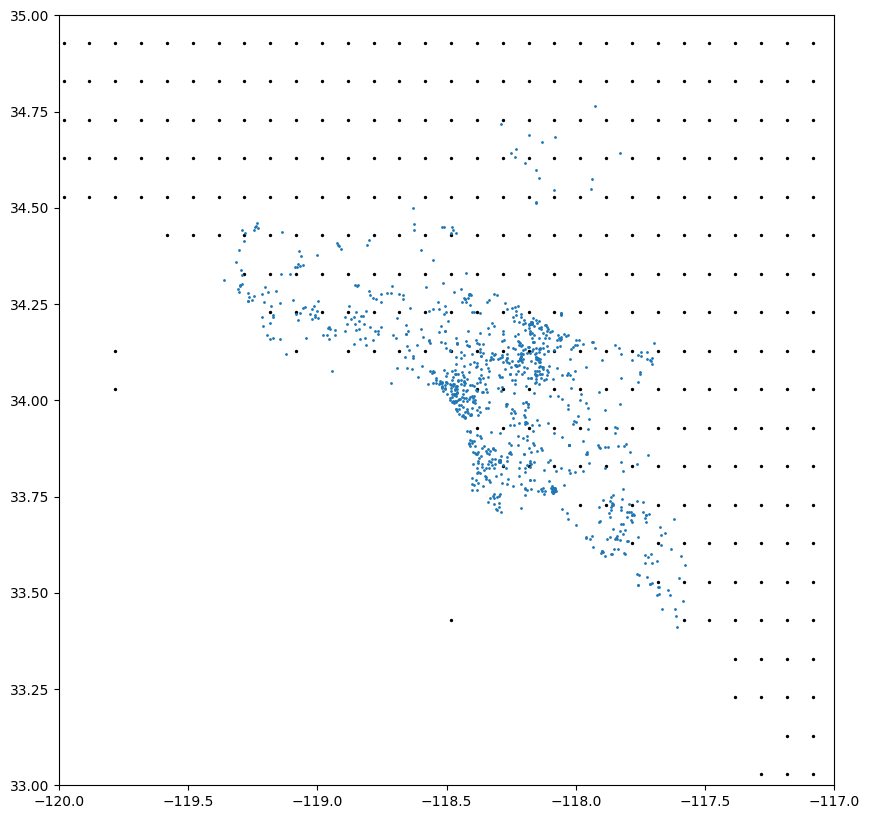

In [19]:
ds = xr.open_mfdataset("/home/patel_zeel/aqmsp/aqmsp_data/datasets/era5/era5_2021_01_03-00.nc")
print(ds)

fig, ax = plt.subplots(figsize=(10, 10))
df = ds.isel(time=10)["u10"].to_dataframe().reset_index()
df = df.dropna(subset=["u10"])
# print(df.columns)
plt.scatter(df["longitude"], df["latitude"], c="k", s=2)
ax.scatter(aq_data["lon"], aq_data["lat"], s=1)
ax.set_xlim(-120, -117)
ax.set_ylim(33, 35)

In [20]:
era_sites = df[["latitude", "longitude"]]
station_sites = aq_data.isel(datetime=0).to_dataframe().reset_index()[["lat", "lon"]]
station_sites = station_sites.rename(columns={"lat": "latitude", "lon": "longitude"})
display(station_sites.head(), era_sites.head(), station_sites.shape, era_sites.shape)

,latitude,longitude
0,34.017452,-118.436905
1,34.159840,-119.182290
2,33.953278,-118.243040
3,34.108900,-118.445200
4,34.067818,-118.254290


,latitude,longitude
4,42.129002,-124.282959
5,42.129002,-124.182953
6,42.129002,-124.082947
7,42.129002,-123.982933
8,42.129002,-123.882927


(1022, 2)

(7695, 2)

In [21]:
# find cdist between all sites
from scipy.spatial.distance import cdist

distances = cdist(era_sites, station_sites)
n_points = len(set(distances.argmin(axis=0).tolist()))
print(f"{n_points} ERA5 locations are shared among {len(station_sites)} stations")

87 ERA5 locations are shared among 1022 stations


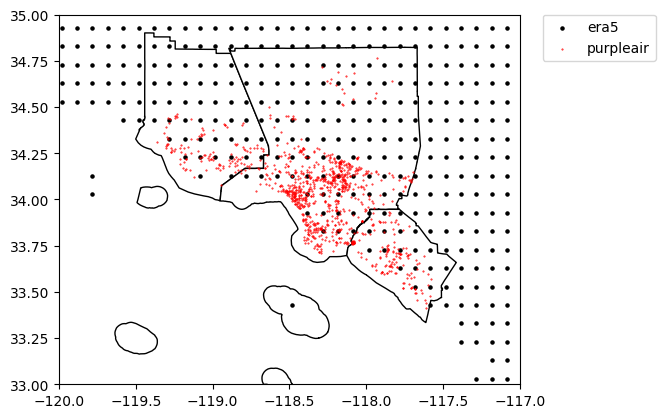

In [22]:
cal_map = gpd.read_file(f"/home/patel_zeel/aqmsp/aqmsp_data/datasets/shapefiles/california/CA_Counties_TIGER2016.shp")
# convert to lat/lon
cal_map = cal_map.to_crs(epsg=4326)
cities = ["Los Angeles", "Orange", "Ventura"]
# plt.scatter(ds['lon'], ds['lat'], s=0.1, c='red')
subset_map = cal_map[cal_map.NAME.isin(cities)]

ds = xr.open_mfdataset("/home/patel_zeel/aqmsp/aqmsp_data/datasets/era5/era5_2021_01_03-00.nc")

fig, ax = plt.subplots()
subset_map.plot(ax=ax, color="white", edgecolor="black")
df = ds.isel(time=0)["t2m"].to_dataframe().reset_index()
df = df.dropna(subset=["t2m"])
# print(df.columns)
plt.scatter(df["longitude"], df["latitude"], c='k', s=5, label="era5")
# plt.scatter(new_df["lon"], new_df["lat"], s=2, color="blue")
ax.scatter(aq_data["lon"], aq_data["lat"], s=0.2, color="red", label="purpleair")
ax.set_xlim(-120, -117)
ax.set_ylim(33, 35)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

## We will take weighted average of 4 nearest grid points for each station

In [23]:
distances.shape

(7695, 1022)

In [24]:
files_2021 = glob("/home/patel_zeel/aqmsp/aqmsp_data/datasets/era5/era5_2021*.nc")
files_2022 = glob("/home/patel_zeel/aqmsp/aqmsp_data/datasets/era5/era5_2022*.nc")
files = files_2021 + files_2022

ds_list = []
for file in tqdm(files):
    ds_list.append(xr.open_dataset(file))

era_ds = xr.concat(ds_list, dim="time").sortby("time")
era_ds

  0%|          | 0/576 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:    (longitude: 108, latitude: 99, time: 17520)
Coordinates:
  * longitude  (longitude) float32 -124.7 -124.6 -124.5 ... -114.2 -114.1 -114.0
  * latitude   (latitude) float32 42.13 42.03 41.93 41.83 ... 32.53 32.43 32.33
  * time       (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 nan nan nan ... 292.9 292.6
    skt        (time, latitude, longitude) float32 nan nan nan ... 295.8 295.5
    d2m        (time, latitude, longitude) float32 nan nan nan ... 282.2 281.8
    sf         (time, latitude, longitude) float32 nan nan ... 3.725e-09
    u10        (time, latitude, longitude) float32 nan nan ... -1.116 -0.7814
    v10        (time, latitude, longitude) float32 nan nan nan ... 5.417 5.414
    sp         (time, latitude, longitude) float32 nan nan ... 9.76e+04
    tp         (time, latitude, longitude) float32 nan nan ... 2.161e-06
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-20 20:54:54 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [45]:
def get_data_for_station(i):
    location_id = aq_data["location_id"][i].item()
    station_lat = station_sites.iloc[i]["latitude"]
    station_lon = station_sites.iloc[i]["longitude"]
    # print("Station id", location_id)
    # print("Station lat/lon", station_lat, station_lon)
    top4 = distances[:, i].argsort()[:4]
    ds_list = []
    weights = []
    for each in top4:
        lat = era_sites.iloc[each]["latitude"]
        lon = era_sites.iloc[each]["longitude"]
        # print(lat, lon, distances[each, i])
        ds = era_ds.sel(latitude=lat, longitude=lon)
        # remove latitude and longitude
        ds = ds.drop(["latitude", "longitude"])
        
        weight = 1 / distances[each, i]        
        ds_list.append(ds * weight)
        weights.append(weight)
    # combine all datasets
    combined = sum(ds_list) / sum(weights)

    combined.coords["location_id"] = location_id
    combined = combined.expand_dims("location_id")
    combined.coords["lat"] = ("location_id", [station_lat])
    combined.coords["lon"] = ("location_id", [station_lon])
    
    # slice for needed time
    combined = combined.sel(time=aq_data.datetime.values)
    combined = combined.rename({"time": "datetime"})
    
    combined["value"] = (("location_id", "datetime"), aq_data.isel(location_id=i)["value"].values.reshape(1, -1))
    return combined
    
era_aq_data_list = Parallel(n_jobs=24)(delayed(get_data_for_station)(i) for i in tqdm(range(len(station_sites))))

  0%|          | 0/1022 [00:00<?, ?it/s]

In [55]:
era_aq_data = xr.concat(era_aq_data_list, dim="location_id")
print(era_aq_data.isnull().sum() / len(era_aq_data["datetime"]) / len(era_aq_data["location_id"]))
display(era_aq_data)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 0.0
    skt      float64 0.0
    d2m      float64 0.0
    sf       float64 0.0
    u10      float64 0.0
    v10      float64 0.0
    sp       float64 0.0
    tp       float64 0.0
    value    float64 0.251


<xarray.Dataset>
Dimensions:      (datetime: 9417, location_id: 1022)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2021-06-01 ... 2022-06-30T23:00:00
  * location_id  (location_id) <U6 '64724' '72255' '67566' ... '227064' '226491'
    lat          (location_id) float64 34.02 34.16 33.95 ... 33.87 34.07 34.09
    lon          (location_id) float64 -118.4 -119.2 -118.2 ... -118.4 -118.4
Data variables:
    t2m          (location_id, datetime) float32 297.4 297.0 ... 304.0 303.5
    skt          (location_id, datetime) float32 308.3 305.9 ... 315.5 314.2
    d2m          (location_id, datetime) float32 285.6 285.7 ... 284.1 283.8
    sf           (location_id, datetime) float32 0.0 0.0 5.821e-11 ... 0.0 0.0
    u10          (location_id, datetime) float32 2.519 1.414 ... 2.524 2.992
    v10          (location_id, datetime) float32 1.491 1.692 ... 2.963 2.667
    sp           (location_id, datetime) float32 9.95e+04 ... 9.893e+04
    tp           (location_id, datetime) float32 2.611e-05 0.0 ... 0.0 0.0
    value        (location_id, datetime) float64 9.663 11.12 ... 17.02 16.11

## Get elevation data

### Appendix

In [ ]:
ds_list = []
for i in range(24):
    i = str(i).zfill(2)
    ds = xr.open_mfdataset(f"/home/patel_zeel/aqmsp/aqmsp_data/datasets/era5/era5_2021_01_{i}-00.nc")
    ds_list.append(ds)
ds = xr.concat(ds_list, dim="time")
ds = ds.sortby("time")
print(ds)

# plot wind vectors
fig, ax = plt.subplots()
f = 1

def plot_it(t):
    u10 = ds['u10'].sel(time=t)
    v10 = ds['v10'].sel(time=t)
    ax.cla()
    cal_map.plot(ax=ax, color="white", edgecolor="black", linewidth=0.5)
    subset_map.plot(ax=ax, color="white", edgecolor="red", linewidth=0.5)
    ax.quiver(u10['longitude'], u10['latitude'], u10*f, v10*f, scale=50, color="green")
    ax.set_xlim(-121, -116)
    ax.set_ylim(32, 36)
    t = pd.to_datetime(t.item()).strftime("%Y-%m-%d %H:%M")
    ax.set_title(t)
    
anim = FuncAnimation(fig, plot_it, frames=tqdm(ds['time'].values[:7*24]), interval=300)
plt.close()
anim

In [ ]:
anim.save("era5_Jan_21_wind.mp4")

In [ ]:
ax.quiver??

In [ ]:
# We could not use the following since it is daily data
# from get_station_data import ghcnd
# from get_station_data.util import nearest_stn

In [ ]:
# stn_md = ghcnd.get_stn_metadata()

In [ ]:
# # find nearest station to each aq station
# new_df = pd.DataFrame(columns=["lat", "lon"], index=range(len(aq_data["lat"])))
# nearests = []

# def get_nearest(i):
#     lat = aq_data["lat"][i]
#     lon = aq_data["lon"][i]
#     nearest = nearest_stn(stn_md, lon, lat, n_neighbours=1)
#     return nearest

# nearests = Parallel(n_jobs=48)(delayed(get_nearest)(i) for i in tqdm(range(len(aq_data["lat"]))))

In [ ]:
# nearests[0]

In [ ]:
# latlons = [n[["lat", "lon"]].values.ravel() for n in nearests if n["end_year"].item() >= 2021 and n["start_year"].item() <= 2021]
# latlons = np.stack(latlons, axis=0)
# new_df = pd.DataFrame(latlons, columns=["lat", "lon"]).drop_duplicates(subset=["lat", "lon"])
# len(new_df)

In [88]:
tds = xr.tutorial.load_dataset("air_temperature")
sum([tds, tds])/2

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7